# Gravitational Lensing

Weak gravitational lensing distorts the images of distant galaxies as their light passes through foreground matter. The convergence field $\kappa$ measures the projected mass along the line of sight, weighted by a lensing efficiency kernel.

This notebook computes convergence maps from PM lightcones using two methods:

| Method | Function | JAX-compatible | Accuracy |
|--------|----------|---------------|----------|
| **Born approximation** | `born()` | Yes (JIT-able) | First-order |
| **Ray-tracing** | `raytrace()` | No (uses dorian/NumPy) | Full post-Born |

The Born approximation integrates the lensing potential along unperturbed light paths. Ray-tracing propagates the full distortion matrix through each lens plane, capturing lens-lens coupling and other post-Born effects.

## Setup

In [34]:
import os

os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.97'

import jax
jax.config.update("jax_platform_name", "cpu")
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt

import fwd_model_tools as ffi

## Run PM Simulation with Spherical Output

We need a spherical lightcone (`SphericalDensity` with `status=LIGHTCONE`) as input for both lensing functions.

In [35]:
key = jax.random.PRNGKey(0)
mesh_size = (200, 200 , 200)
box_size = (500.0, 500.0, 500.0)
nside = 64
nb_shells = 8
cosmo = ffi.Planck18()

initial_field = ffi.gaussian_initial_conditions(
    key, mesh_size, box_size,
    cosmo=cosmo,
    nside=nside,
)

dx, p = ffi.lpt(cosmo, initial_field, scale_factor_spec=0.1, order=1)

solver = ffi.ReversibleDoubleKickDrift(
    interp_kernel=ffi.DriftInterp(painting=ffi.PaintingOptions(target="spherical", scheme="bilinear")),
)
lightcone = ffi.nbody(
    cosmo, dx, p,
    t1=1.0, dt0=0.05,
    nb_shells=nb_shells,
    solver=solver,
)

print(f"Lightcone shape: {lightcone.shape}")
print(f"Scale factors: {lightcone.scale_factors}")

Lightcone shape: (8, 49152)
Scale factors: [0.99489462 0.98468385 0.97447308 0.96462325 0.95482144 0.94510788
 0.9356917  0.92627552]


## Redshift Distributions

Lensing convergence is computed for specific source galaxy populations. The `nz_shear` parameter defines the redshift distribution $n(z)$ of source galaxies. We can use:
- `tophat_z(zmin, zmax)`: simple top-hat distribution
- `get_stage3_nz_shear()`: realistic 4-bin tomographic distributions from Stage 3 surveys

In [ ]:
# Simple top-hat distributions at two redshifts
nz_sources = ffi.io.get_stage3_nz_shear()


In [23]:
nz_sources[0].params[1].max()

Array(2.80521782, dtype=float64)

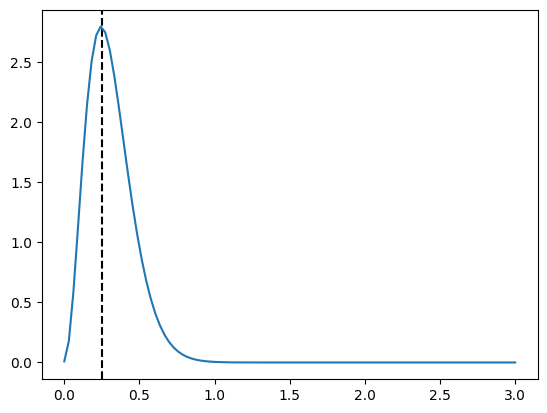

In [33]:
z_grid = jnp.linspace(0.0, 3.0, 100)
plt.axvline(0.25, color="k", ls="--")
plt.plot(z_grid, nz_sources[0](z_grid))

In [25]:
nz_sources[0](2.805)

Array([6.77017222e-18], dtype=float64)

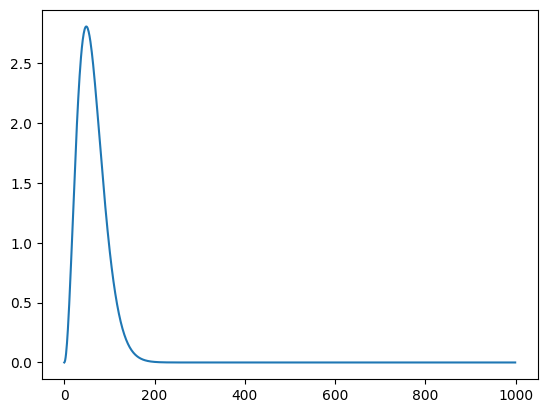

In [21]:
plt.plot(nz_sources[0].params[1], label=f"Source bin {i}")

## Born Approximation

The Born approximation is fast and fully differentiable (JIT-compatible). It integrates the weighted projected density along straight (unperturbed) light paths.

In [37]:
lightcone.z_sources

Array([0.00513158, 0.01555439, 0.02619561, 0.03667416, 0.04731624,
       0.05808027, 0.06872809, 0.07959239], dtype=float64)

Born kappa type: SphericalKappaField
Born kappa shape: (1, 49152)


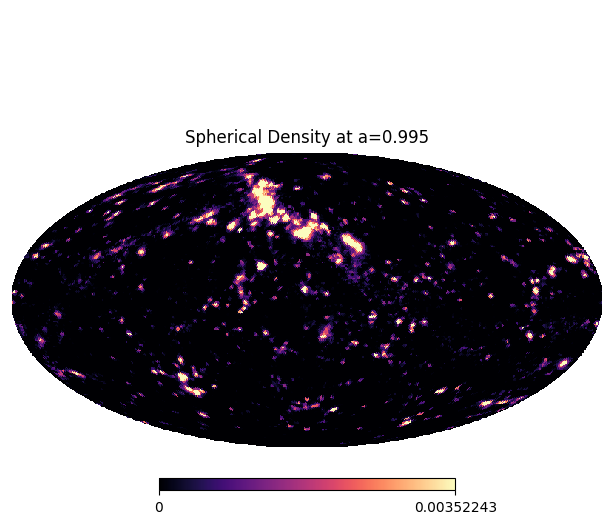

In [38]:
kappa_born = ffi.born(cosmo, lightcone, nz_shear=jnp.array([0.07]))

print(f"Born kappa type: {type(kappa_born).__name__}")
print(f"Born kappa shape: {kappa_born.shape}")
kappa_born.show(ncols=2)

## Ray-tracing

Full ray-tracing propagates the distortion matrix through each lens plane, capturing post-Born corrections. This requires the `dorian` library (`pip install fwd-model-tools[raytrace]`) and cannot be JIT-compiled.

/home/wassim/Projects/NBody/dorian/dorian/raytracing.py:180: RuntimeWarning: divide by zero encountered in divide
  alpha_lm = hp.almxfl(kappa_lm, -2 / (np.sqrt((ell * (ell + 1)))))
/home/wassim/Projects/NBody/dorian/dorian/raytracing.py:181: RuntimeWarning: divide by zero encountered in divide
  f_l = -np.sqrt((ell + 2.0) * (ell - 1.0) / (ell * (ell + 1.0))) # Must safe divide
/home/wassim/Projects/NBody/dorian/dorian/raytracing.py:181: RuntimeWarning: invalid value encountered in sqrt
  f_l = -np.sqrt((ell + 2.0) * (ell - 1.0) / (ell * (ell + 1.0))) # Must safe divide


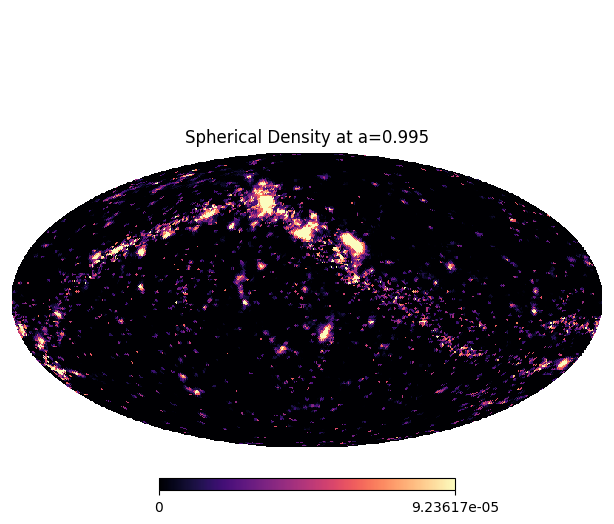

In [40]:
kappa_rt = ffi.raytrace(cosmo, lightcone,  nz_shear=jnp.array([0.07]) , born=True)
kappa_rt.show()


## Theory Comparison

Compare measured convergence power spectra against the theoretical prediction from `compute_theory_cl` with `probe_type="weak_lensing"`.

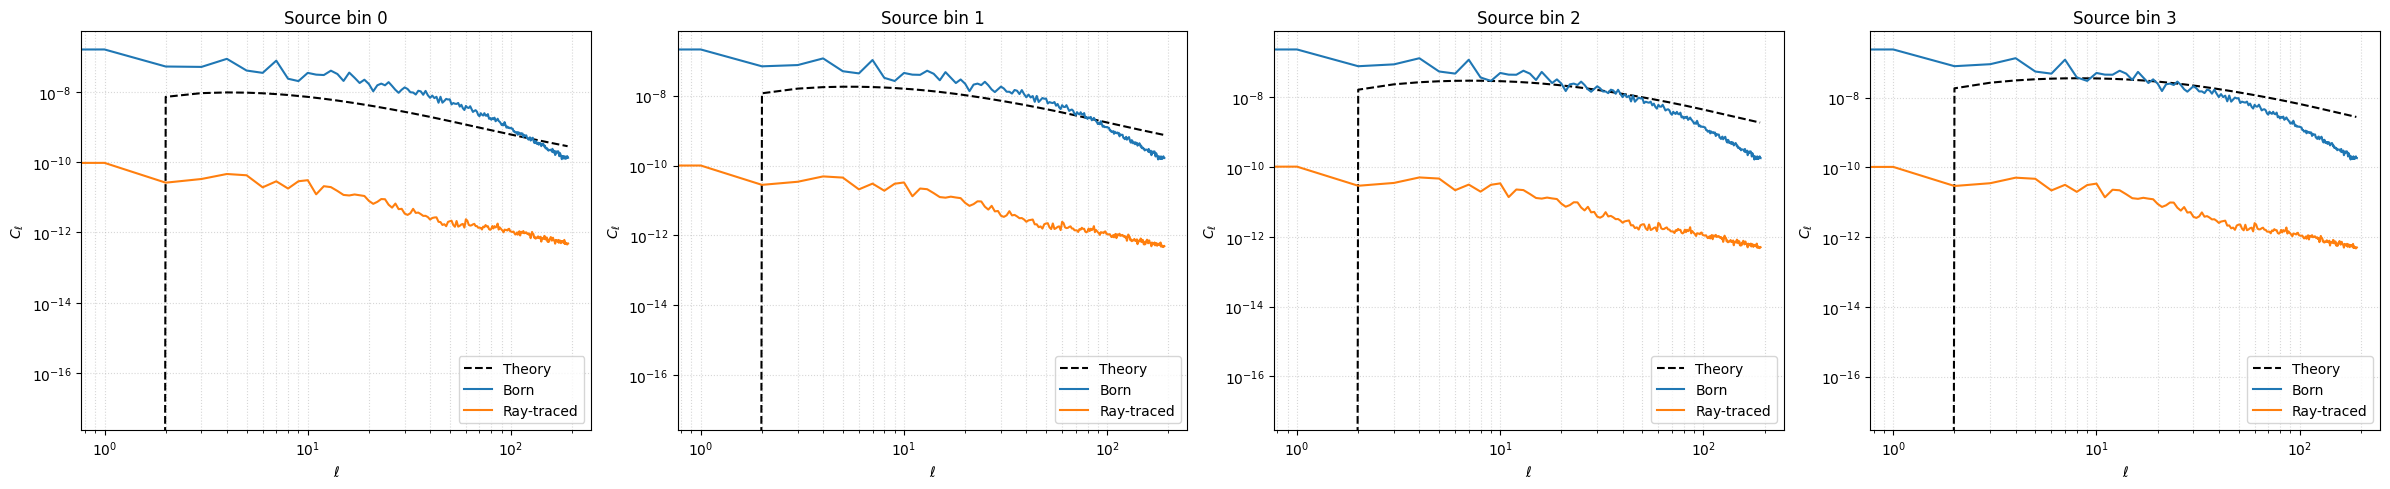

In [6]:
LMAX = 3 * nside - 1
ells = jnp.arange(LMAX)

theory_cl = ffi.compute_theory_cl(
    cosmo, ell=ells, z_source=nz_sources,
    probe_type="weak_lensing", nonlinear_fn=jc.power.halofit, cross=False,
)

# Born power spectra
cl_born = kappa_born.angular_cl(method="healpy")
cl_rt = kappa_rt.angular_cl(method="healpy")

n_sources = len(nz_sources)
fig, axes = plt.subplots(1, n_sources, figsize=(6 * n_sources, 5))
if n_sources == 1:
    axes = [axes]

for i in range(n_sources):
    theory_cl[i].plot(ax=axes[i], logx=True, logy=True, label=["Theory"], color="black", linestyle="--")
    cl_born[i].plot(ax=axes[i], logx=True, logy=True, label=["Born"], color="tab:blue")

    cl_rt[i].plot(ax=axes[i], logx=True, logy=True, label=["Ray-traced"], color="tab:orange")

    axes[i].set_title(f"Source bin {i}")
    axes[i].legend()

plt.tight_layout()
plt.show()

## Born vs Ray-tracing Difference

Quantify the post-Born corrections by comparing the two convergence maps directly.